In [4]:
import pandas as pd

df = pd.read_csv(r"C:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Giorno 20 30-04\esercitazione\AB_NYC_2019.csv")
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [5]:
df.drop(columns=['id', 'name', 'host_name', 'last_review'], inplace=True)

In [6]:
df["reviews_per_month"].fillna(0, inplace=True)

C:\Users\fabri\AppData\Local\Temp\ipykernel_11796\1901275697.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["reviews_per_month"].fillna(0, inplace=True)


RMSE: 196.66
R²: 0.1258


<Figure size 1200x600 with 0 Axes>

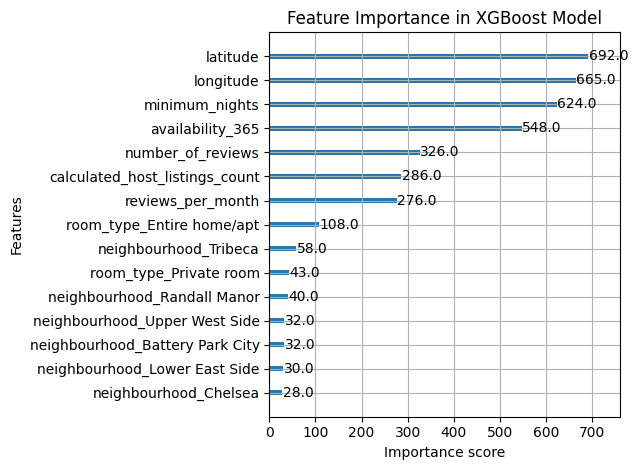

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define features and target (assuming we want to predict price)
X = df.drop(columns=['price', 'host_id'])
y = df['price']

# Handle categorical variables
X = pd.get_dummies(X, columns=['neighbourhood_group', 'neighbourhood', 'room_type'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DMatrix objects for XGBoost
# Identify numerical columns for scaling
numerical_columns = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                    'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

# Create a scaler and fit it on the training data
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

# Transform the test data using the same scaler
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist'  # Added histogram-based tree method
}

# Train the model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

# Make predictions
y_pred = model.predict(dtest)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.4f}')

# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, max_num_features=15)
plt.title('Feature Importance in XGBoost Model')
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation RMSE: 222.75
Best model RMSE: 190.90
Best model R²: 0.1762


AttributeError: 'XGBRegressor' object has no attribute 'plot_importance'

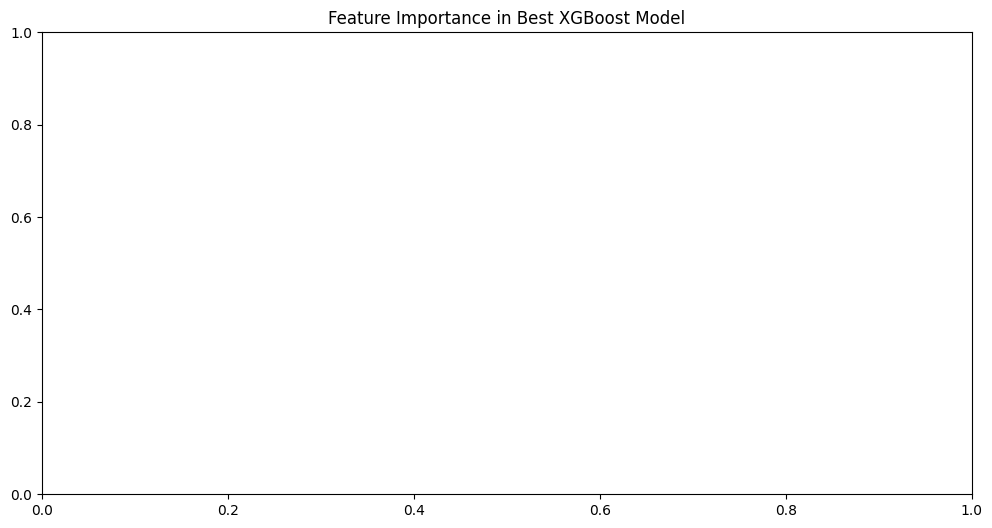

In [8]:
# grid search
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Create an XGBoost regressor
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42
)

# Define parameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'min_child_weight': [1, 5]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation RMSE: {-best_score:.2f}")

# Train model with best parameters
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    **best_params
)

best_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_best = best_model.predict(X_test)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f'Best model RMSE: {rmse_best:.2f}')
print(f'Best model R²: {r2_best:.4f}')

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.title('Feature Importance in Best XGBoost Model')
best_model.plot_importance(max_num_features=15)
plt.tight_layout()
plt.show()